In [244]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import  MCMT, ZGate, XGate
from qiskit.visualization import plot_distribution
from qiskit_aer.primitives import Sampler

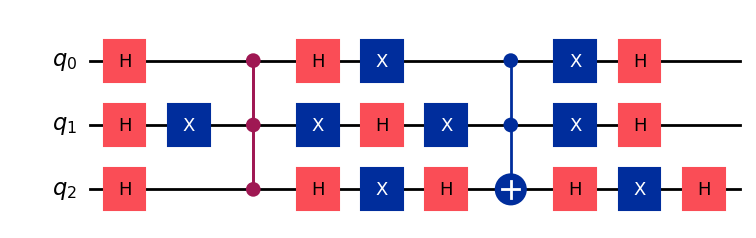

In [245]:
##Code for application of Grover algoirthm for single target 


##Define function to apply the phase oracle and mark the desired state

#To mark the gate we need to use a multi control gate, applying a single z gate applies only on qubits not computational basis states, to act on a basis state you need to use a multi control gate to apply a z gate on a basis state as specified in the following documentation 
#https://www.quantum-inspire.com/kbase/grover-algorithm/
#https://learning.quantum.ibm.com/tutorial/grovers-algorithm
#https://medium.com/analytics-vidhya/grovers-algorithm-in-python-c1dfa132e3af

def oracle(qc, state):
    """
    Build the Oracle which marks a given state for the Grover search algorithm 
    
    :param qc: The quantum circuit containing the information you wish to search 
    :param state: The state to be targeted 
    :return: The quantum circuit with the marked state 
    """
    # Reverse the state to get it into proper format 
    state = list(reversed(state))
    
    # Flip all 0's to 1's in order to trigger control gate
    # Apply X gates where necessary
    for qubit, bit in enumerate(state):
        if bit == "0":
            qc.x(qubit)
    
    # Apply the multi-controlled Z gate
    n = len(state) - 1  # Number of control qubits (all except last qubit)
    qc.append(MCMT(ZGate(), num_ctrl_qubits=n, num_target_qubits=1), qc.qubits[:len(state)])
    
    
    # Reverse the X gates to revert to original state
    for qubit, bit in enumerate(state):
        if bit == "0":
            qc.x(qubit)
    
    # Return the modified quantum circuit
    return qc
    
    
## Next define function to apply the Grover diffusion operator
def diffusion_operator(qc):
    '''
    Build the diffusion operator to amplify the amplitude of the marked state 
    
    :param qc: The Quantum cirquit with the marked state 
    :return: The Quantum circuit with the diffusion operator appended 
    '''
    #Apply the corresponding gates to the given circuit as per the circuit diagram in the notes
    
    #Apply Hadamard and X gate on all qubits 
    n = qc.num_qubits 
    qc.h(range(n))
    qc.x(range(n))
    
    #Apply Hadamard on last qubit 
    qc.h(n-1)
    
    #Apply MultiControl-Xgate on the last qubit 
    
    qc.append(MCMT(XGate(), num_ctrl_qubits=n-1, num_target_qubits=1), qc.qubits[:n])
    
    
    #Apply Hadamard on last qubit and then x and Hadamard gates to aLL qubits
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    
    return qc
    
#Define number of qubits and the circuit 
target = "101"
n = len(target)
qc = QuantumCircuit(n)


#Step 1: Create a superposition by applying a Hadamard to all qubits
qc.h(range(n))

#Step 2: Mark target state by applying oracle
qc = oracle(qc,target)

#Step 3: Apply Diffusion Operator to Amplify Amplitude of target state pi/4(sqrt(N)) times 
qc = diffusion_operator(qc)

#Decompose the gates Control Gates
qc = qc.decompose(gates_to_decompose='mcmt')



#Lastly draw the circuit
qc.draw('mpl')


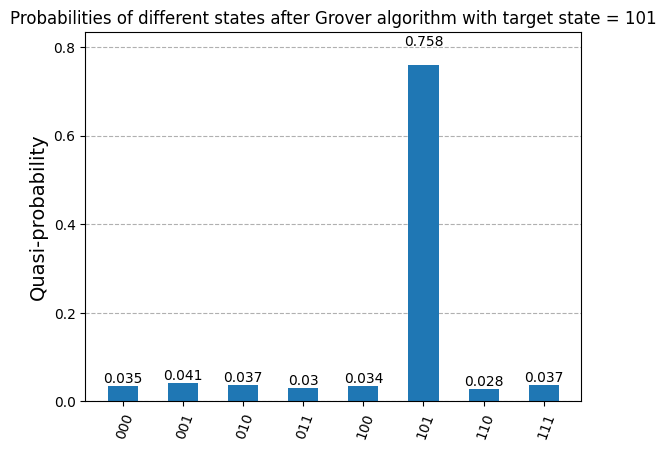

In [246]:
#Measure the results and display results 
qc.measure_all()
 
#Extract the results from sampler and covert them to binary
results = Sampler().run(qc, shots=1000).result().quasi_dists[0]
binary_results = {format(key, f'0{n}b'): value for key, value in results.items()}

#Display the results 
plot_histogram(binary_results, title=f"Probabilities of different states after Grover algorithm with target state = {target}")

***Please note here that the target state is the state with the highest probability indicating successful amplification***

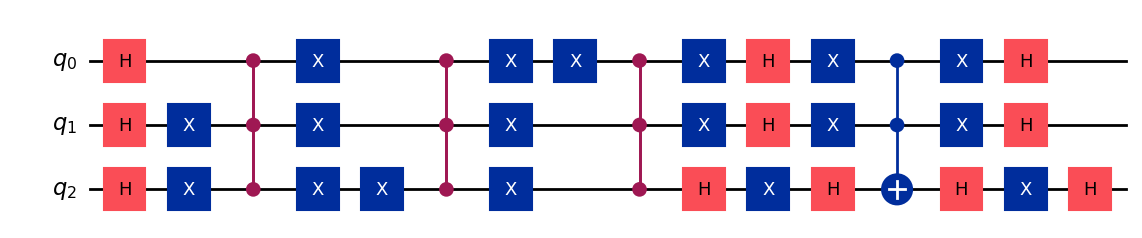

In [247]:
### Now lets make it so we can handle multiple target items represented as a list of binary strings 


##We need to modify the previous functions to accept a list of strings rather than just one. This can be done easily by repeating the oracle algorithm for each element in targets, the diffusion operator can remain unchanged since it amplifies any marked state

def oracle2(qc, states):
    """
    Build the Oracle which marks a list of given states for the Grover search algorithm 
    
    :param qc: The quantum circuit containing the information you wish to search 
    :param state: The state to be targeted 
    :return: The quantum circuit with the marked state 
    """
    # Reverse the state to get it into proper format 
    for state in states:      
        state = list(reversed(state))
        
    
     # Flip all 0's to 1's in order to trigger control gate
     # Apply X gates where necessary
        for qubit, bit in enumerate(state):
            if bit == "0":
                qc.x(qubit)
    
        # Apply the multi-controlled Z gate
        n = len(state) - 1  # Number of control qubits (all except last qubit)
        qc.append(MCMT(ZGate(), num_ctrl_qubits=n, num_target_qubits=1), qc.qubits[:len(state)])
    
    
    # Reverse the X gates to revert to original state
        for qubit, bit in enumerate(state):
            if bit == "0":
                
                qc.x(qubit)
    
    # Return the modified quantum circuit
    return qc
    

    
    
##Initiazlie the list of targets 
targets = ["001","010","100"]

##Note here I take n to be the length of the first target string which would produce an error if the targets are not all the same length given this is a personal project I assume perfect input 

n = len(targets[0])
qc2 = QuantumCircuit(n)
#Step 1: Create a superposition by applying a Hadamard to all qubits
qc2.h(range(n))

#Step 2: Mark target state by applying oracle
qc2 = oracle2(qc2,targets)

#Step 3: Apply Diffusion Operator to Amplify Amplitude of target state 
qc2 = diffusion_operator(qc2)

#Decompose the gates Control Gates
qc2 = qc2.decompose(gates_to_decompose='mcmt')

#Lastly draw the circuit
qc2.draw('mpl')


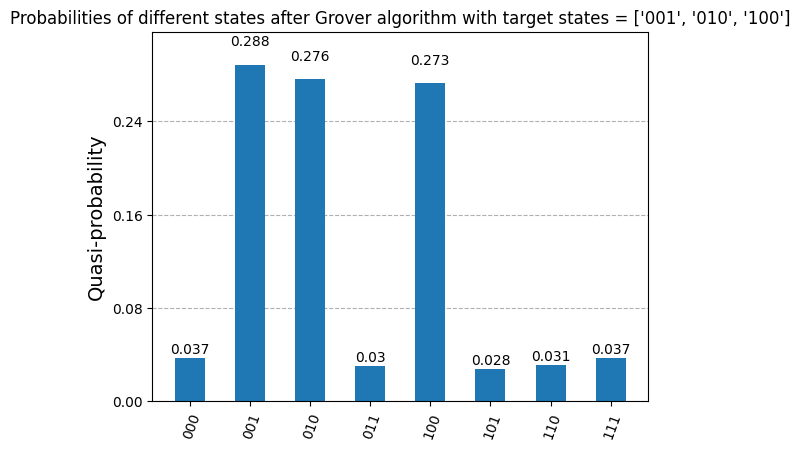

In [248]:
#Measure the results and display results 
qc2.measure_all()

#Extract the results from sampler and covert them to binary
results2 = Sampler().run(qc2, shots=1000).result().quasi_dists[0]
binary_results2 = {format(key, f'0{n}b'): value for key, value in results2.items()}

#Display the results 
plot_histogram(binary_results2, title=f"Probabilities of different states after Grover algorithm with target states = {targets}")

***Similarily target states here have the highest probabilities indicating successful application of Grover algorithm***